In this lab you'll be doing a bit more of a comprehensive analysis. Despite coming from Kaggle, this will not be a competition. Check out the data source and context here:

https://www.kaggle.com/datasets/riinuanslan/sleep-data-from-fitbit-trackerLinks to an external site.

It's a relatively simple dataset, but your goal is this: 

Can we predict Sleep Score (posted by the FitBit app) using the other metrics in the dataset? In other words, is there a formula here that the FitBit app uses to compute Sleep Score that we can reverse-engineer?
Two constraints for this assignment:

1. Your modeling efforts must involve bagging and stacking in some way. Otherwise, you may try whatever you like.

2. You are allowed, even encouraged, to compute and/or gather additional features to use as explanatory variables in your model. For example, you might create a variable for the time they went to sleep (as a measure of how "early" they went to bed, or not). There are multiple datasets and you should use all of them, which means you may use the corresponding month for the dataset as a variable as well (or anything related to it).

# Import Data

In [113]:
import pandas as pd

# November
nov = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/November Sleep Data - Sheet1.csv")
nov["MONTH"] = 'NOVEMBER'
nov.rename(columns={'NOVEMBER': 'WEEKDAY'}, inplace=True)
november = nov[1:]

# December
dec = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/December Sleep data - Sheet1.csv")
dec["MONTH"] = 'DECEMBER'
dec.rename(columns={'DECEMBER': 'WEEKDAY'}, inplace=True)
december = dec[1:]

# January
jan = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/January sleep data - Sheet1.csv")
jan["MONTH"] = 'JANUARY'
jan.rename(columns={'JANUARY': 'WEEKDAY'}, inplace=True)
jan.rename(columns={'HEART RATE UNDER RESTING': 'HEART RATE BELOW RESTING'}, inplace=True)
january = jan[1:]

# February
feb = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/February sleep data - Sheet1 (1).csv")
feb["MONTH"] = 'FEBRUARY'
feb.rename(columns={'FEBEUARY': 'WEEKDAY'}, inplace=True)
feb.rename(columns={'SLEEP SQORE': 'SLEEP SCORE'}, inplace=True)
february = feb[1:]

# March
mar = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/March sleep data - Sheet1.csv")
mar["MONTH"] = 'MARCH'
mar.rename(columns={'MARCH': 'WEEKDAY'}, inplace=True)
mar.rename(columns={'HEARTRATE BELOW RESTING': 'HEART RATE BELOW RESTING'}, inplace=True)
march = mar[1:]

# April
apr = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/April sleep data - Sheet1.csv")
apr["MONTH"] = 'APRIL'
apr.rename(columns={'APRIL': 'WEEKDAY'}, inplace=True)
april = apr[1:]

df = pd.concat([november, december, january, february, march, april], ignore_index=True)

## Data Setup
### Add bed time and wake time categorical variables

In [114]:
from datetime import datetime, time

fitBit = df.copy()

# Function to parse sleep and wake times from string
def parse_sleep_wake(s):
    try:
        sleep_str, wake_str = s.lower().split(" - ")
        sleep_time = datetime.strptime(sleep_str.strip(), "%I:%M%p").time()
        wake_time = datetime.strptime(wake_str.strip(), "%I:%M%p").time()
        return sleep_time, wake_time
    except:
        return None, None  # if parsing fails

# Apply parsing
fitBit[['BED_TIME', 'WAKE_TIME']] = fitBit['SLEEP TIME'].apply(lambda x: pd.Series(parse_sleep_wake(x)))

# Categorization functions
def categorize_bedtime(t):
    if t is None: return 'unknown'
    if t < time(22, 0):         # Before 10:00 PM
        return 'early'
    elif t <= time(23, 30):     # 10:00 PM to 11:30 PM
        return 'average'
    else:                       # After 11:30 PM
        return 'late'

def categorize_wake_time(t):
    if t is None: return 'unknown'
    if t < time(6, 30):         # Before 6:30 AM
        return 'early'
    elif t <= time(9, 0):       # 6:30 AM to 9:00 AM
        return 'average'
    else:                       # After 9:00 AM
        return 'late'

# Apply categorization
fitBit['SLEEP_CATEGORY'] = fitBit['BED_TIME'].apply(categorize_bedtime)
fitBit['WAKE_CATEGORY'] = fitBit['WAKE_TIME'].apply(categorize_wake_time)

#fitBit.to_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week2/FitBit/cleaned_fitbit_data.csv", index=False)

fitBit

,WEEKDAY,DATE,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,SLEEP TIME,MONTH,BED_TIME,WAKE_TIME,SLEEP_CATEGORY,WAKE_CATEGORY
0,Monday,11/1/2021,88.0,8:06:00,20.00%,13.00%,84.00%,10:41pm - 7:54am,NOVEMBER,22:41:00,07:54:00,average,average
1,Tuesday,11/2/2021,83.0,7:57:00,12.00%,18.00%,90.00%,10:40pm - 7:55am,NOVEMBER,22:40:00,07:55:00,average,average
2,Wednesday,11/3/2021,81.0,7:06:00,13.00%,22.00%,93.00%,11:03pm - 7:16am,NOVEMBER,23:03:00,07:16:00,average,average
3,Thursday,11/4/2021,86.0,7:04:00,19.00%,17.00%,97.00%,10:55pm - 6:56am,NOVEMBER,22:55:00,06:56:00,average,average
4,Friday,11/5/2021,81.0,9:24:00,17.00%,15.00%,66.00%,10:14pm - 9:01am,NOVEMBER,22:14:00,09:01:00,average,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Tuesday,04/26/2022,85.0,7:18:00,22.00%,14.00%,100.00%,9:32pm - 6:00am,APRIL,21:32:00,06:00:00,early,early
174,Wednesday,04/27/2022,90.0,7:34:00,24.00%,19.00%,98.00%,9:19pm - 5:49am,APRIL,21:19:00,05:49:00,early,early
175,Thursday,04/28/2022,87.0,6:54:00,21.00%,22.00%,90.00%,10:02pm - 5:46am,APRIL,22:02:00,05:46:00,average,early
176,Friday,04/29/2022,86.0,7:45:00,19.00%,17.00%,95.00%,10:15pm - 7:24am,APRIL,22:15:00,07:24:00,average,average


### Clean Data

Functions for cleaning columns

In [115]:
import pandas as pd
import numpy as np

def convert_to_minutes(series):
    """
    Converts a pandas Series with time strings (H:MM[:SS]) into total minutes.
    Handles missing seconds by appending ':00' if needed.
    """
    def to_minutes(x):
        if isinstance(x, str):
            parts = x.split(":")
            if len(parts) == 2:
                x += ":00"
            try:
                td = pd.to_timedelta(x)
                return td.total_seconds() / 60
            except:
                return np.nan
        return np.nan

    return series.apply(to_minutes)

def clean_percentage(series):
    """
    Converts a Series of percentage strings (e.g., '85%') to float (e.g., 85.0).
    Safely handles NaN and invalid inputs.
    """
    return series.str.rstrip('%').astype(float)

Cleaning process
- Convert all information in strings to floats
- Drop columns that give no information

In [116]:
cleanBit = fitBit.copy()

# Fix "HOURS OF SLEEP" strings to total minutes
cleanBit["SLEEP_MINUTES"] = convert_to_minutes(cleanBit["HOURS OF SLEEP"])

# Fix "REM SLEEP", "DEEP SLEEP", and "HEART RATE BELOW RESTING" strings to percentage floats
cleanBit["REM SLEEP"] = clean_percentage(cleanBit["REM SLEEP"])
cleanBit["DEEP SLEEP"] = clean_percentage(cleanBit["DEEP SLEEP"])
cleanBit["HEART RATE BELOW RESTING"] = clean_percentage(cleanBit["HEART RATE BELOW RESTING"])

# Drop unneeded columns
cleanBit = cleanBit.drop(columns=["DATE", "BED_TIME", "WAKE_TIME", "SLEEP TIME", "HOURS OF SLEEP"])

# Add weekend flag
cleanBit["WEEKEND"] = cleanBit["WEEKDAY"].isin(["Saturday", "Sunday"]).astype(int)

cleanBit

,WEEKDAY,SLEEP SCORE,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,MONTH,SLEEP_CATEGORY,WAKE_CATEGORY,SLEEP_MINUTES,WEEKEND
0,Monday,88.0,20.0,13.0,84.0,NOVEMBER,average,average,486.0,0
1,Tuesday,83.0,12.0,18.0,90.0,NOVEMBER,average,average,477.0,0
2,Wednesday,81.0,13.0,22.0,93.0,NOVEMBER,average,average,426.0,0
3,Thursday,86.0,19.0,17.0,97.0,NOVEMBER,average,average,424.0,0
4,Friday,81.0,17.0,15.0,66.0,NOVEMBER,average,late,564.0,0
...,...,...,...,...,...,...,...,...,...,...
173,Tuesday,85.0,22.0,14.0,100.0,APRIL,early,early,438.0,0
174,Wednesday,90.0,24.0,19.0,98.0,APRIL,early,early,454.0,0
175,Thursday,87.0,21.0,22.0,90.0,APRIL,average,early,414.0,0
176,Friday,86.0,19.0,17.0,95.0,APRIL,average,average,465.0,0


## Set up for modeling

In [117]:
from sklearn.preprocessing import LabelEncoder

fitBit_final = cleanBit.dropna().copy()
X = fitBit_final.drop(columns=['SLEEP SCORE'])
y = fitBit_final["SLEEP SCORE"]

# To make string variables into categories
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

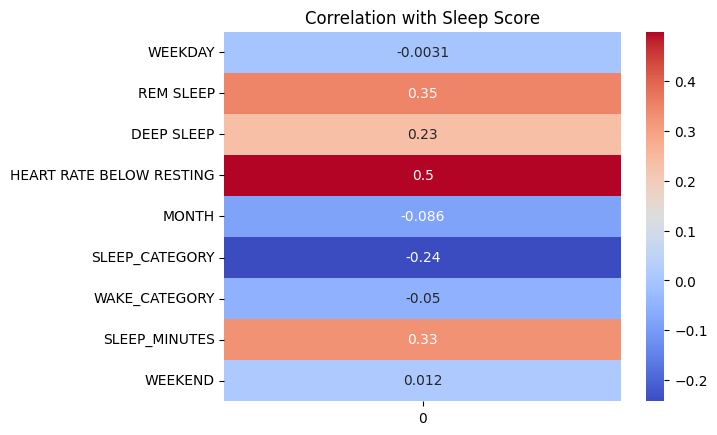

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X_encoded.corrwith(y).to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation with Sleep Score")
plt.show()

# Ensemble Models
## Bagging Approach

In [119]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from numpy import mean, std

# Define the model
bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=7, min_samples_split=4), #max_depth -Controls tree complexity (try 5–10)
    n_estimators=100,        #min_samples_split -Prevents overfitting on small data splits
    max_samples=0.9,         #How much data each tree sees (0.6–1.0)
    max_features=0.8,        #Fraction of features per tree (helps generalization)
    bootstrap=True,
    bootstrap_features=False,
    random_state=1
)

# Evaluate
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Score
scores_mae = cross_val_score(bag, X_encoded, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(bag, X_encoded, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(bag, X_encoded, y, scoring='r2', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (-mean(scores_mae), std(scores_mae)))
print('MSE: %.3f (%.3f)' % (-mean(scores_mse), std(scores_mse)))
print('R^2: %.3f (%.3f)' % (mean(scores_r2), std(scores_r2)))

MAE: 2.315 (0.969)
MSE: 28.688 (61.355)
R^2: 0.382 (0.471)


## Random Forest Approach

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from numpy import mean, std

# Define the model
rf = RandomForestRegressor(
    n_estimators=200,      #Number of trees in the forest — more trees = more robust but slower
    max_depth=10,          #Maximum depth of each tree — limits overfitting and controls model complexity
    min_samples_split=4,   #Minimum number of samples required to split a node — helps prevent overfitting
    max_features='sqrt',   #Number of features to consider when looking for best split — 'sqrt' adds randomness, improves generalization
    random_state=1 
)

# Evaluate
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Score
scores_mae = cross_val_score(rf, X_encoded, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(rf, X_encoded, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(rf, X_encoded, y, scoring='r2', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (-mean(scores_mae), std(scores_mae)))
print('MSE: %.3f (%.3f)' % (-mean(scores_mse), std(scores_mse)))
print('R^2: %.3f (%.3f)' % (mean(scores_r2), std(scores_r2)))

MAE: 2.151 (0.977)
MSE: 26.289 (61.579)
R^2: 0.562 (0.271)


## Stacking Approach

In [121]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Use regression models only
models = [
    ('knn', KNeighborsRegressor()),
    ('svr', SVR()),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=7, random_state=1))
]

stack = StackingRegressor(
    estimators=models,
    final_estimator=LinearRegression(),  # Meta-model
    passthrough=True,                    
    cv=5,
    n_jobs=-1
)

# Cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Score
scores_mae = cross_val_score(stack, X_encoded, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_mse = cross_val_score(stack, X_encoded, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(stack, X_encoded, y, scoring='r2', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (-mean(scores_mae), std(scores_mae)))
print('MSE: %.3f (%.3f)' % (-mean(scores_mse), std(scores_mse)))
print('R^2: %.3f (%.3f)' % (mean(scores_r2), std(scores_r2)))

MAE: 2.272 (0.865)
MSE: 26.105 (60.747)
R^2: 0.510 (0.318)


# Evaluate best model

In [126]:
bag.fit(X_encoded, y)
rf.fit(X_encoded, y)
stack.fit(X_encoded, y)

pass

In [127]:
preds_bag = bag.predict(X_encoded)
preds_rf = rf.predict(X_encoded)
preds_stack = stack.predict(X_encoded)

In [128]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_preds(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

results = {
    "Bagging": evaluate_preds(y, preds_bag),
    "RandomForest": evaluate_preds(y, preds_rf),
    "Stacking": evaluate_preds(y, preds_stack)
}

import pandas as pd
pd.DataFrame(results).T

,MAE,MSE,R2
Bagging,1.294038,8.839706,0.778132
RandomForest,1.039241,8.339764,0.790680
Stacking,1.833065,16.792770,0.578518


Thus, based on our evaluation, the best model to use is our random forrest because it has the lowest MAE and MSE as well as the highest R^2 after fitting to the data.

### Plot to show actual vs predicted sleep scores

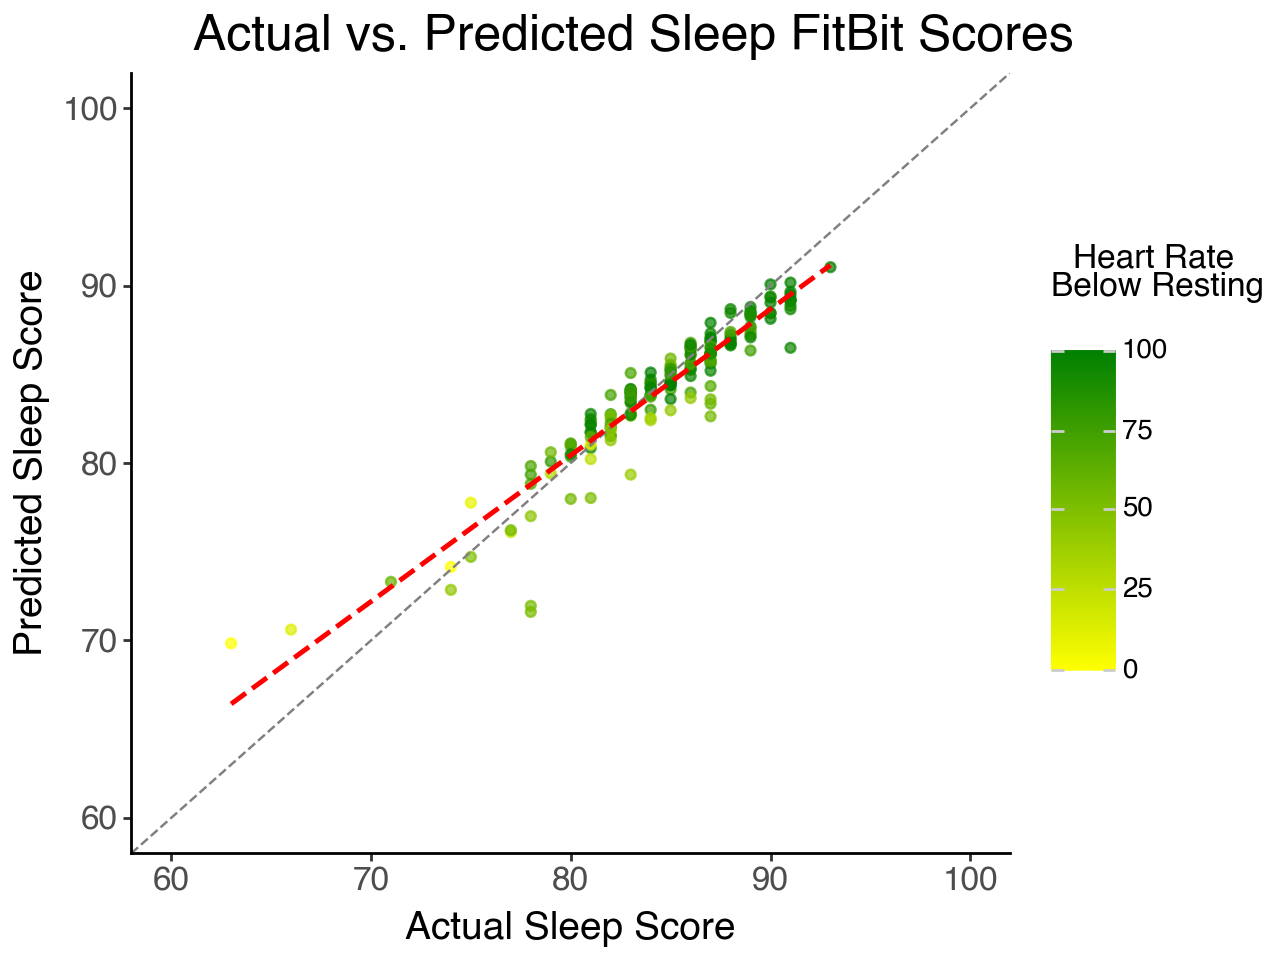

In [129]:
import warnings
from plotnine.exceptions import PlotnineWarning

from plotnine import (
    ggplot, aes, geom_point, geom_abline, geom_smooth, labs, ggtitle,
    theme_classic, scale_x_continuous, scale_y_continuous, scale_color_gradient,
    theme, element_text, geom_text
)
import pandas as pd

# Rebuild your plot DataFrame (adjust as needed)
plot_df = pd.DataFrame({
    "Actual": y,
    "Predicted": preds_bag,
    "SLEEP_MINUTES": X_encoded["HEART RATE BELOW RESTING"]  # this should be total minutes of sleep
})

# Optional: calculate residuals and mark large errors
plot_df["Residual"] = plot_df["Predicted"] - plot_df["Actual"]

line_df = pd.DataFrame({
    "linetype_label": ["Perfect Prediction", "Model Trend"],
    "slope": [1, None],
    "intercept": [0, None]
})

# Build the polished ggplot
p = (
    ggplot(plot_df, aes(x="Actual", y="Predicted", color="SLEEP_MINUTES")) +
    geom_point(alpha=0.7, size=1.5) +
    geom_abline(intercept=0, slope=1, color="grey", linetype="dashed", size=.5) +
    geom_smooth(method="lm", se=False, linetype="dashed", color="red") +
    scale_color_gradient(name="Heart Rate \nBelow Resting\n", low="yellow", high="green") +
    scale_x_continuous(limits=(60, 100)) +
    scale_y_continuous(limits=(60, 100)) +
    labs(
        x="Actual Sleep Score",
        y="Predicted Sleep Score",
        title="         Actual vs. Predicted Sleep FitBit Scores",
        color="Heart Rate Below Resting"
    ) +
    theme_classic() +
    theme(
        axis_title=element_text(size=14),
        axis_text=element_text(size=12),
        plot_title=element_text(size=18, weight='bold'),
        legend_title=element_text(size=12),
        legend_text=element_text(size=10)
    )
)
# Suppress plotnine warnings
warnings.filterwarnings("ignore", category=PlotnineWarning)
p.show()


Here we can see how our models predictions compare to the actual sleep score and how the trend line(red dashed) compares to the perfect prediction line(grey dashed). On top of this we can analyze the heart rate below resting, our most correlated feature to sleep score, by the gradient scale of the individual points.